In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.model_selection import ParameterGrid

from recsys4daos.models import NLPSimilarity
from recsys4daos.utils import Timer
from recsys4daos.datasets import to_microsoft
from recsys4daos.evaluation import calculate_all_metrics
from recsys4daos.model_selection import cvtt_open, explore_hparams

import paths

import seaborn as sns
sns.set_theme()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/home/daviddavo/recsys4daos/.direnv/python-3.11/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Parameters

In [2]:
# Dataset config
ORG_NAME = 'Decentraland'

# Evaluation
K_RECOMMENDATIONS: list[int] = [1,3,5,10,15,100]
SPLITS_FREQ: str = 'W-THU' # split weekly
SPLITS_NORMALIZE = True # Wether or not to move everything to 00:00
LAST_FOLDS = 10 # Use just last 10 splits
LAST_FOLD_DATE_STR: str = None

# Search space config
WINDOW_SIZES = ['7d', '14d', '21d', '30d', '60d', '90d', '10YE']
MODEL_NAMES = [
    'all-mpnet-base-v2', # The one used in sbert's examples
    'all-distilroberta-v1',
    'all-MiniLM-L12-v2',
    'all-MiniLM-L6-v2',
]

OPTIM_METRIC = 'map@10'

In [3]:
# Parameters
EXECUTION_ID = "2024-09-04T10:00"
ORG_NAME = "MetaCartel - MetaCartel Ventures"
SPLITS_FREQ = "W-THU"
LAST_FOLDS = 10
SPLITS_NORMALIZE = True
LAST_FOLD_DATE_STR = "2022-01-06"


In [4]:
EMBEDDINGS_CACHE = Path(paths.DEFAULT_CACHE_PATH) / 'pln-embeddings'

# Load the dataset

In [5]:
dfp = paths.load_proposals(ORG_NAME, text=True)
dfv = paths.load_votes(ORG_NAME)

print(dfp.info())
print(dfv.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1088 entries, 0 to 1087
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 1088 non-null   object        
 1   author             1088 non-null   object        
 2   date               1088 non-null   datetime64[us]
 3   start              1088 non-null   datetime64[us]
 4   end                807 non-null    datetime64[us]
 5   platform_proposal  1088 non-null   object        
 6   title              1087 non-null   object        
 7   description        909 non-null    object        
dtypes: datetime64[us](3), object(5)
memory usage: 68.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        3287 non-null   object        
 1   proposal  3287 non-null   obje

In [6]:
df = to_microsoft(dfv)
df

,userID,itemID,timestamp,rating
0,0x865c2f85c9fea1c6ac7f53de07554d68cb92ed88,a3cd7b01-435c-50cd-8d8c-75102df1027c,2019-06-06 09:49:38,1
1,0x865c2f85c9fea1c6ac7f53de07554d68cb92ed88,83841f4c-18bf-57ef-bb9f-f0383b99fd32,2019-06-07 07:03:42,1
2,0x865c2f85c9fea1c6ac7f53de07554d68cb92ed88,5c99eeb2-9854-5d2d-ba20-1ff1307ea924,2019-06-07 07:04:48,1
3,0x865c2f85c9fea1c6ac7f53de07554d68cb92ed88,fc0c49e1-5e4a-528b-92e3-42b3fb560d16,2019-06-10 10:49:11,1
4,0x865c2f85c9fea1c6ac7f53de07554d68cb92ed88,7179b537-bb7e-5677-adcd-3f44fcc78805,2019-06-10 10:49:31,1
...,...,...,...,...
3282,0xe2a82cdccbfa6ebf9817b0c4aed45264bd41fbec,52983d9e-5fd1-5afd-8c2a-936b38d65f06,2023-06-23 16:28:23,1
3283,0x6dc43be93a8b5fd37dc16f24872babc6da5e5e3e,06f50c00-d777-55c6-917b-ff9c0cf7f3ce,2023-06-28 20:30:25,1
3284,0xbaf6e57a3940898fd21076b139d4ab231dcbbc5f,06f50c00-d777-55c6-917b-ff9c0cf7f3ce,2023-06-28 22:00:45,1
3285,0xe2a82cdccbfa6ebf9817b0c4aed45264bd41fbec,6d79288e-6319-565e-9316-3b9027f6ec8e,2023-07-07 17:52:59,1


## Split in folds

In [7]:
all_folds = { f.end:f for f in cvtt_open(
    df, SPLITS_FREQ, dfp.reset_index(), remove_not_in_train_col='userID', last_fold=LAST_FOLD_DATE_STR,
)}
last_folds_idx = list(all_folds.keys())[-LAST_FOLDS:]
last_folds_idx

[Timestamp('2021-11-04 00:00:00'),
 Timestamp('2021-11-11 00:00:00'),
 Timestamp('2021-11-18 00:00:00'),
 Timestamp('2021-11-25 00:00:00'),
 Timestamp('2021-12-02 00:00:00'),
 Timestamp('2021-12-09 00:00:00'),
 Timestamp('2021-12-16 00:00:00'),
 Timestamp('2021-12-23 00:00:00'),
 Timestamp('2021-12-30 00:00:00'),
 Timestamp('2022-01-06 00:00:00')]

# Similarity PLN

In [8]:
def testHParamsPLNSimilarity(fold, window_size, model_name):
    f = all_folds[fold]
    
    model = NLPSimilarity(dfp, EMBEDDINGS_CACHE, model_name=model_name)

    offset = pd.tseries.frequencies.to_offset(window_size)
    train = f.train[f.train['timestamp'] > (f.end - offset)]

    with Timer() as t_fit:
        model.fit(train)

    with Timer() as t_rec:
        # Truncate the top_k
        top_k = max(K_RECOMMENDATIONS)
        users = np.intersect1d(f.test['userID'].unique(), train['userID'].unique())
        recs = model.recommend_k_items(users, top_k=min(len(f.open_proposals), top_k), recommend_from=f.open_proposals)
    
    return {
        'time_train': t_fit.time,
        'time_rec': t_rec.time,
        'rec_users': len(users),
        **calculate_all_metrics(f.test, recs, K_RECOMMENDATIONS),
    }

# testHParamsPLNSimilarity(last_folds_idx[0], '14D', MODEL_NAMES[0])

In [9]:
# Populate the cache of embeddings for each model
from recsys4daos.models.nlp import NLPModel

for m in MODEL_NAMES:
    NLPModel(dfp, EMBEDDINGS_CACHE, model_name=m).fit()

In [10]:
results = explore_hparams(
    testHParamsPLNSimilarity,
    ParameterGrid({
        'fold': last_folds_idx,
        'model_name': MODEL_NAMES,
        'window_size': WINDOW_SIZES,
    }),
    paths.hparams_progress('pln-similarity', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE),
)
mdf = pd.DataFrame(results)
mdf

Restored checkpoint from ../.cache/MetaCartel - MetaCartel Ventures/hparams-pln-similarity_W-THU_normalize.pkl with 280 results


  0%|          | 0/280 [00:00<?, ?it/s]

,fold,model_name,window_size,time_train,time_rec,rec_users,precision@1,precision@3,precision@5,precision@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
0,2021-11-04,all-mpnet-base-v2,7d,0.226621,0.001441,5,0.200000,0.266667,0.240000,0.160000,...,0.108462,0.616538,1.0,0.125000,0.163462,0.155128,0.180769,0.219231,0.334615,0.133078
1,2021-11-04,all-mpnet-base-v2,14d,0.077032,0.001411,5,0.400000,0.200000,0.280000,0.220000,...,0.131538,0.639615,1.0,0.081731,0.100962,0.167949,0.219231,0.257692,0.360256,0.131674
2,2021-11-04,all-mpnet-base-v2,21d,0.228494,0.001397,6,0.500000,0.222222,0.266667,0.200000,...,0.276282,0.699679,1.0,0.387821,0.400641,0.375962,0.414423,0.443269,0.520192,0.132424
3,2021-11-04,all-mpnet-base-v2,30d,0.079203,0.001528,7,0.428571,0.285714,0.228571,0.171429,...,0.236813,0.614011,1.0,0.387821,0.455128,0.375962,0.414423,0.443269,0.529808,0.136174
4,2021-11-04,all-mpnet-base-v2,60d,0.231673,0.001498,7,0.285714,0.190476,0.171429,0.185714,...,0.256319,0.310440,1.0,0.519231,0.392308,0.438462,0.448558,0.487019,0.573558,0.136645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,2022-01-06,all-MiniLM-L6-v2,21d,0.068443,0.001221,1,0.000000,0.333333,0.200000,0.100000,...,1.000000,1.000000,1.0,0.000000,NaN,NaN,NaN,NaN,NaN,0.116102
276,2022-01-06,all-MiniLM-L6-v2,30d,0.217526,0.001290,2,0.500000,0.166667,0.200000,0.100000,...,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.122909
277,2022-01-06,all-MiniLM-L6-v2,60d,0.226007,0.001294,2,0.500000,0.166667,0.200000,0.100000,...,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.122584
278,2022-01-06,all-MiniLM-L6-v2,90d,0.070380,0.001284,2,0.500000,0.166667,0.200000,0.100000,...,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.124281


<Axes: xlabel='window_size', ylabel='map@10'>

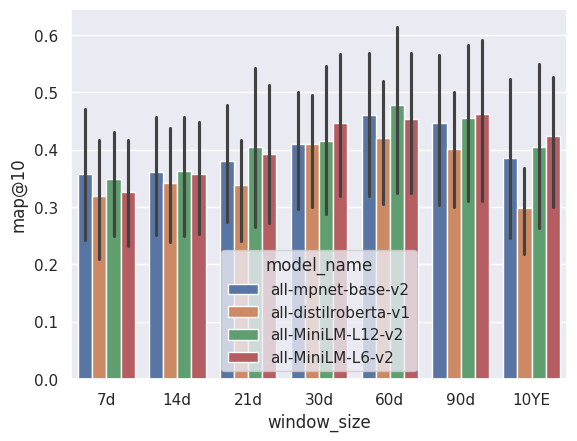

In [11]:
sns.barplot(mdf, x='window_size', y=OPTIM_METRIC, hue='model_name')

## Best overall hparams

In [12]:
display_columns = ['time_train'] + [ c for c in mdf.columns if c.endswith('@5') or c.endswith('@10') or c.endswith('@100') ]
hparam_cols = ['window_size', 'model_name']
overall_hparams = mdf[mdf['fold'] > last_folds_idx[0]].groupby(hparam_cols).mean().sort_values(OPTIM_METRIC, ascending=False)
overall_hparams[display_columns]

,,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
window_size,model_name,,,,,,,,,,,,,,,,
60d,all-MiniLM-L12-v2,0.137354,0.258069,0.152381,0.021442,0.515952,0.559182,0.633763,0.479203,0.499850,0.531606,0.629586,0.766667,1.0,0.668951,0.668951,0.752569
90d,all-MiniLM-L6-v2,0.121378,0.270723,0.151499,0.021371,0.556349,0.578384,0.652416,0.480967,0.493176,0.523262,0.696296,0.763404,1.0,0.618210,0.618210,0.695486
60d,all-mpnet-base-v2,0.203216,0.268254,0.165344,0.021442,0.509111,0.566912,0.621410,0.456460,0.483550,0.506267,0.652734,0.822222,1.0,0.613580,0.613580,0.690278
90d,all-MiniLM-L12-v2,0.157922,0.257143,0.150265,0.021371,0.526061,0.566211,0.643650,0.460746,0.479701,0.511996,0.634568,0.757231,1.0,0.650432,0.650432,0.731736
60d,all-MiniLM-L6-v2,0.186650,0.243783,0.157937,0.021442,0.505518,0.555862,0.619130,0.445172,0.475722,0.500728,0.658245,0.794444,1.0,0.567593,0.567593,0.638542
90d,all-mpnet-base-v2,0.168757,0.261376,0.158907,0.021371,0.513662,0.566814,0.631571,0.444331,0.467620,0.494844,0.635891,0.791182,1.0,0.595062,0.595062,0.669444
30d,all-MiniLM-L6-v2,0.152199,0.250450,0.154497,0.021349,0.498718,0.538191,0.590554,0.443011,0.467486,0.495676,0.670591,0.780635,1.0,0.621914,0.621914,0.699653
60d,all-distilroberta-v1,0.152980,0.217857,0.151720,0.021442,0.462656,0.528485,0.604024,0.404652,0.440643,0.474547,0.580467,0.761530,1.0,0.583333,0.656250,0.656250
10YE,all-MiniLM-L6-v2,0.206237,0.252429,0.160113,0.021461,0.503135,0.550453,0.614699,0.412429,0.440262,0.467208,0.673850,0.792725,1.0,0.634568,0.734722,0.734722


In [13]:
best_avg_hparams = mdf.set_index(hparam_cols).loc[overall_hparams.iloc[0].name].reset_index().set_index(['fold', *hparam_cols])
paths.save_model_results(best_avg_hparams, 'plnsim-best-avg', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, K_RECOMMENDATIONS)
best_avg_hparams

Saved dataframe into /home/daviddavo/recsys4daos/data/output/MetaCartel - MetaCartel Ventures/models/plnsim-best-avg_W-THU_normalize.parquet


/tmp/ipykernel_3811077/971293119.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  best_avg_hparams = mdf.set_index(hparam_cols).loc[overall_hparams.iloc[0].name].reset_index().set_index(['fold', *hparam_cols])


,,,time_train,time_rec,rec_users,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
fold,window_size,model_name,,,,,,,,,,,,,,,,,,,,,
2021-11-04,60d,all-MiniLM-L12-v2,0.074220,0.001376,7,0.285714,0.285714,0.228571,0.185714,0.152381,0.068571,0.285714,...,0.247527,0.264011,1.0,0.519231,0.335096,0.369712,0.433173,0.462019,0.538942,0.131503
2021-11-11,60d,all-MiniLM-L12-v2,0.220029,0.001401,4,0.000000,0.000000,0.000000,0.000000,0.033333,0.022500,0.000000,...,0.000000,0.187500,1.0,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.099896
2021-11-18,60d,all-MiniLM-L12-v2,0.070353,0.001333,6,0.666667,0.222222,0.200000,0.116667,0.111111,0.018333,0.571429,...,0.816667,0.966667,1.0,1.000000,1.000000,0.840000,0.840000,0.840000,0.840000,0.130412
2021-11-25,60d,all-MiniLM-L12-v2,0.070511,0.001311,3,0.333333,0.222222,0.133333,0.100000,0.066667,0.010000,0.333333,...,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.127621
2021-12-02,60d,all-MiniLM-L12-v2,0.071660,0.001284,8,0.500000,0.416667,0.275000,0.150000,0.100000,0.015000,0.363636,...,1.000000,1.000000,1.0,0.583333,0.666667,0.666667,0.666667,0.666667,0.666667,0.128874
2021-12-09,60d,all-MiniLM-L12-v2,0.219601,0.001342,2,0.500000,0.333333,0.500000,0.300000,0.266667,0.040000,0.500000,...,0.666667,1.000000,1.0,0.166667,0.333333,0.666667,0.666667,0.666667,0.666667,0.126392
2021-12-16,60d,all-MiniLM-L12-v2,0.070402,0.001299,3,0.666667,0.333333,0.200000,0.133333,0.177778,0.030000,0.666667,...,0.416667,0.916667,1.0,0.291667,0.458333,0.458333,0.458333,0.458333,0.458333,0.126785
2021-12-23,60d,all-MiniLM-L12-v2,0.220162,0.001308,7,0.285714,0.380952,0.314286,0.171429,0.114286,0.017143,0.285714,...,1.000000,1.000000,1.0,0.666667,0.722222,0.722222,0.722222,0.722222,0.722222,0.126775
2021-12-30,60d,all-MiniLM-L12-v2,0.069815,0.001252,1,1.000000,0.666667,0.600000,0.300000,0.200000,0.030000,1.000000,...,1.000000,1.000000,1.0,0.333333,0.666667,0.666667,0.666667,0.666667,0.666667,0.122494


## best hparams by fold

In [14]:
print("Best hyperparams by fold", OPTIM_METRIC)
best_hparams = mdf.sort_values(OPTIM_METRIC,ascending=False).drop_duplicates(['fold'], keep='first').sort_values('fold').set_index(['fold', 'model_name', 'window_size'])
paths.save_model_results(best_hparams, 'plnsim-best-val', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, K_RECOMMENDATIONS)
best_hparams[display_columns]

Best hyperparams by fold map@10
Saved dataframe into /home/daviddavo/recsys4daos/data/output/MetaCartel - MetaCartel Ventures/models/plnsim-best-val_W-THU_normalize.parquet


,,,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
fold,model_name,window_size,,,,,,,,,,,,,,,,
2021-11-04,all-distilroberta-v1,21d,0.241412,0.266667,0.216667,0.078333,0.355033,0.403021,0.534285,0.351667,0.339120,0.424176,0.250641,0.603205,1.0,0.375962,0.404808,0.520192
2021-11-11,all-MiniLM-L6-v2,10YE,0.240788,0.000000,0.025000,0.022500,0.000000,0.044310,0.267182,0.000000,0.012500,0.060777,0.000000,0.125000,1.0,0.000000,NaN,NaN
2021-11-18,all-mpnet-base-v2,10YE,0.100549,0.171429,0.114286,0.017143,0.735153,0.776623,0.831001,0.721429,0.736735,0.762225,0.742857,0.842857,1.0,0.866667,0.866667,0.866667
2021-11-25,all-MiniLM-L12-v2,90d,0.218960,0.133333,0.100000,0.010000,0.543643,0.648798,0.648798,0.500000,0.541667,0.541667,0.666667,1.000000,1.0,1.000000,1.000000,1.000000
2021-12-02,all-mpnet-base-v2,7d,0.230732,0.200000,0.166667,0.016667,0.190928,0.216718,0.216718,0.611111,0.672222,0.672222,0.777778,1.000000,1.0,0.666667,0.666667,0.666667
2021-12-09,all-MiniLM-L6-v2,14d,0.068717,0.200000,0.500000,0.060000,0.169580,0.348906,0.391110,0.200000,0.469577,0.560486,0.166667,0.833333,1.0,0.166667,0.333333,0.333333
2021-12-16,all-distilroberta-v1,30d,0.238065,0.266667,0.166667,0.030000,0.429168,0.484888,0.660691,0.322222,0.377778,0.458207,0.388889,0.500000,1.0,0.416667,0.416667,0.416667
2021-12-23,all-MiniLM-L6-v2,90d,0.071974,0.314286,0.171429,0.017143,0.795972,0.819853,0.819853,0.690476,0.714286,0.714286,0.952381,1.000000,1.0,0.638889,0.638889,0.638889
2021-12-30,all-MiniLM-L12-v2,21d,0.067789,0.600000,0.300000,0.030000,0.967468,0.967468,0.967468,0.916667,0.916667,0.916667,1.000000,1.000000,1.0,0.666667,0.666667,0.666667


In [15]:
best_hparams.describe()[display_columns]

,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.000000,9.000000,9.000000
mean,0.172200,0.235238,0.186071,0.029179,0.488037,0.540401,0.603053,0.491357,0.538055,0.571071,0.594588,0.790440,1.0,0.579818,0.665966,0.678787
std,0.082495,0.154486,0.133061,0.022593,0.312703,0.290775,0.248787,0.273685,0.254272,0.231720,0.367383,0.295595,0.0,0.338136,0.251289,0.238940
min,0.067789,0.000000,0.025000,0.010000,0.000000,0.044310,0.216718,0.000000,0.012500,0.060777,0.000000,0.125000,1.0,0.000000,0.333333,0.333333
25%,0.079118,0.178571,0.103571,0.016786,0.231954,0.362435,0.426904,0.329583,0.400728,0.479072,0.285203,0.660737,1.0,0.386138,0.416667,0.520192
50%,0.224846,0.200000,0.166667,0.019821,0.486405,0.566843,0.654745,0.550000,0.570833,0.580243,0.704762,0.921429,1.0,0.652778,0.666667,0.666667
75%,0.240107,0.266667,0.205357,0.030000,0.724721,0.755824,0.788246,0.670635,0.703770,0.703770,0.908730,1.000000,1.0,0.816667,0.866667,0.866667
max,0.243013,0.600000,0.500000,0.078333,0.967468,0.967468,0.967468,0.916667,0.916667,0.916667,1.000000,1.000000,1.0,1.000000,1.000000,1.000000


### Results of using best hparams on next fold

In [16]:
next_hparams_idx = best_hparams.index.to_frame(False)
next_hparams_idx['fold'] = next_hparams_idx['fold'].shift(-1)
next_hparams_idx = next_hparams_idx.dropna()
assert len(next_hparams_idx) == len(best_hparams)-1
next_hparams = mdf.set_index(['fold', 'model_name', 'window_size']).loc[pd.MultiIndex.from_frame(next_hparams_idx)]
paths.save_model_results(next_hparams, 'plnsim-best-test', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, K_RECOMMENDATIONS)
next_hparams[display_columns]

Saved dataframe into /home/daviddavo/recsys4daos/data/output/MetaCartel - MetaCartel Ventures/models/plnsim-best-test_W-THU_normalize.parquet


,,,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
fold,model_name,window_size,,,,,,,,,,,,,,,,
2021-11-11,all-distilroberta-v1,21d,0.079780,0.000000,0.000000,0.020000,0.000000,0.000000,0.133781,0.000000,0.000000,0.064027,0.000000,0.000000,1.0,0.000000,0.000000,NaN
2021-11-18,all-MiniLM-L6-v2,10YE,0.237675,0.200000,0.114286,0.017143,0.561500,0.576085,0.634034,0.452381,0.458730,0.489675,0.814286,0.842857,1.0,0.600000,0.600000,0.600000
2021-11-25,all-mpnet-base-v2,10YE,0.252626,0.133333,0.100000,0.010000,0.376977,0.482132,0.482132,0.277778,0.319444,0.319444,0.666667,1.000000,1.0,NaN,NaN,NaN
2021-12-02,all-MiniLM-L12-v2,90d,0.219580,0.266667,0.133333,0.015556,0.451643,0.451643,0.482254,0.411728,0.411728,0.426038,0.888889,0.888889,1.0,0.555556,0.555556,0.555556
2021-12-09,all-mpnet-base-v2,7d,0.079589,0.200000,0.500000,0.060000,0.169580,0.348906,0.391110,0.200000,0.469577,0.560486,0.166667,0.833333,1.0,0.166667,0.333333,0.333333
2021-12-16,all-MiniLM-L6-v2,14d,0.219075,0.100000,0.150000,0.025000,0.156426,0.264288,0.368589,0.166667,0.293651,0.342694,0.166667,0.500000,1.0,0.333333,0.333333,0.333333
2021-12-23,all-distilroberta-v1,30d,0.082677,0.314286,0.157143,0.017143,0.616064,0.616064,0.631845,0.486111,0.486111,0.494048,0.952381,0.952381,1.0,0.611111,0.611111,0.611111
2021-12-30,all-MiniLM-L6-v2,90d,0.218482,0.600000,0.300000,0.030000,0.852928,0.852928,0.852928,0.700000,0.700000,0.700000,1.000000,1.000000,1.0,0.333333,0.333333,0.333333
2022-01-06,all-MiniLM-L12-v2,21d,0.067866,0.200000,0.100000,0.010000,0.250000,0.250000,0.250000,0.333333,0.333333,0.333333,1.000000,1.000000,1.0,NaN,NaN,NaN


In [17]:
next_hparams.describe()[display_columns]

,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.0,7.000000,7.000000,6.000000
mean,0.161928,0.223810,0.172751,0.022760,0.381680,0.426894,0.469630,0.336444,0.385842,0.414416,0.628395,0.779718,1.0,0.371429,0.395238,0.461111
std,0.080938,0.168392,0.145536,0.015381,0.267630,0.247301,0.217365,0.205478,0.189170,0.179772,0.404087,0.331732,0.0,0.233233,0.216772,0.141203
min,0.067866,0.000000,0.000000,0.010000,0.000000,0.000000,0.133781,0.000000,0.000000,0.064027,0.000000,0.000000,1.0,0.000000,0.000000,0.333333
25%,0.079780,0.133333,0.100000,0.015556,0.169580,0.264288,0.368589,0.200000,0.319444,0.333333,0.166667,0.833333,1.0,0.250000,0.333333,0.333333
50%,0.218482,0.200000,0.133333,0.017143,0.376977,0.451643,0.482132,0.333333,0.411728,0.426038,0.814286,0.888889,1.0,0.333333,0.333333,0.444444
75%,0.219580,0.266667,0.157143,0.025000,0.561500,0.576085,0.631845,0.452381,0.469577,0.494048,0.952381,1.000000,1.0,0.577778,0.577778,0.588889
max,0.252626,0.600000,0.500000,0.060000,0.852928,0.852928,0.852928,0.700000,0.700000,0.700000,1.000000,1.000000,1.0,0.611111,0.611111,0.611111
